# Web Scraping for Indeed.com and Predicting Salaries

## Introduction

This project was an assignment during the Data Science Immersive course I took at General Assembly. In this project, I practice two major skills: collecting data by scraping a website, and building a binary predictor with Logistic Regression.

I collect salary information on data science jobs in Indeed.com using BeautifulSoup. Then, using the location, title, and summary of the job, I attempt to predict the salary of the job. I convert this problem into classification and use Logistic Regression to predict salaries.

## Part 1 - Scraping job listings from Indeed.com

The first stage involved collecting the data that models would be based on. Indeed.com was scraped for four pieces of information in each job: location, company, job, and salary.

### Import relevant libraries

In [58]:
import pandas as pd
import requests
import bs4
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from scrapy.selector import Selector
from scrapy.http import HtmlResponse


plt.style.use('ggplot')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

### Configure Beautiful Soup to obtain HTML from website

In [ ]:
URL ="https://www.indeed.com/jobs?q=data+scientist+$20,000&l=New+York&start=60"

In [4]:
html = requests.get(URL)

In [5]:
soup = BeautifulSoup(html.text, 'html.parser')

### Write 4 functions to extract each item: location, company, job, and salary.

For each of these functions, I went through the HTML on the webpage to locate the labels used to categorise the data. XPath Helper was useful to do this. After that, these functions were written to automate collection.

In [8]:
def extract_job_title_from_result(soup):
    title_list = []
    html = soup.find_all('a',class_= 'turnstileLink')
    for element in html:
        try:
            title_list.append(element['title'])
        except:
            title_list.append(np.nan)
    return title_list

#### Example Use:

In [9]:
extract_job_title_from_result(soup)

[u'Analyst, Research',
 u'Associate Research Scientist/Scholar',
 u'Machine Learning',
 u'Data Science Manager \u2013 Premium Analytics',
 u'Image Data Scientist',
 u'Scientist (Water Ecology)',
 u'DATA SCIENCE ANALYST III',
 u'Machine Learning Engineer (Associate) - Intelligent Solutions',
 u'Data Scientist/Engineer',
 u'Sr. Field Data Scientist']

In [10]:
def extract_location_from_result(soup):
    location_list = []
    html = soup.find_all('span',class_= 'location')
    for element in html:
        try:
            location_list.append(element.contents[0])
        except:
            try:
                location_list.append(element.contents)
            except:
                location_list.append(np.nan)
        #try/except: If the search returns a child with more location data,
        #only show parent, else show all (else add N/A)
    return location_list

#### Example Use:

In [11]:
extract_location_from_result(soup)

[u'New York, NY',
 u'New York State',
 u'New York, NY',
 u'New York, NY 10011 ',
 u'New York, NY',
 u'New York, NY',
 u'New York, NY 10029 ',
 u'New York, NY 10001 ',
 u'New York, NY',
 u'New York, NY 10001 ']

In [237]:
def extract_company_from_result(soup):
    company_list = []
    html = soup.find_all('div', {'data-tn-component':'organicJob'})
    for element in html:
        try:
            if len(element.find('span', {'class' : 'company'}).contents[0]) > 1:
                company_list.append(element.find('span', {'class' : 'company'}).contents[0])
            else: 
                company_list.append(np.nan)
        except:
            company_list.append(np.nan)
    return company_list

#### Example Use:

In [238]:
extract_company_from_result(soup)

[u'\n    Info Group NW',
 u'\n    DUNTHORPE MARKETING GROUP',
 u'\n    roboboogie',
 u'\n    AbSci',
 u'\n    Amtex Enterprises Inc',
 u'\n    Info Group NW',
 nan,
 u'\n    PointOne Recruiting',
 u'\n    Acumen Executive Search',
 nan]

In [220]:
soup.find('span', {'class' : 'company'}).contents[0]

u'\n    Info Group NW'

In [15]:
def extract_salary_from_result(soup):
    salary_list = []
    html = soup.find_all('div', {'data-tn-component':'organicJob'})
    for element in html:
        try:
            salary_list.append(element.find('span', {'class':'no-wrap'}).text)
        except:
            salary_list.append(np.nan)
    return salary_list

### Increase collection scope from one page to all pages

The previous functions so far only scrape a single page of data. In this section, a function is written which can iterate through a list of cities, obtaining a specified number of results for each city.

In [17]:
YOUR_CITY = 'London'

In [59]:
url_template = "http://www.indeed.com/jobs?q=data+scientist+%2420%2C000&l={}&start={}"
max_results_per_city = 990 # Set this to a high-value (5000) to generate more results. 
# Crawling more results, will also take much longer. First test your code on a small number of results and then expand.

results = []

for city in set(['New+York', 'Chicago', 'San+Francisco', 'Austin', 'Seattle', 
    'Los+Angeles', 'Philadelphia', 'Atlanta', 'Dallas', 'Pittsburgh', 
    'Portland', 'Phoenix', 'Denver', 'Houston', 'Miami', YOUR_CITY]):
    for start in range(0, max_results_per_city, 10):
        # Grab the results from the request (as above)
        URL =url_template.format(city, start)
        html = requests.get(URL)
        soup = BeautifulSoup(html.text, 'html.parser')
        # Append to the full set of results
        results.append(soup)

### Create a dataframe from the results with parsed data

The following code takes the parsed data and inputs it into a Pandas DataFrame object

In [60]:
# Check if results were scraped properly
len(results)

1584

In [239]:
company_list = []
title_list = []
location_list = []
salary_list = []
for n in range(len(results)):
    company_list_temp = extract_company_from_result(results[n])
    for i in range(len(company_list_temp)):
        company_list.append(company_list_temp[i])
    
    title_list_temp = extract_job_title_from_result(results[n])
    for i in range(len(title_list_temp)):
        title_list.append(title_list_temp[i])
    
    location_list_temp = extract_location_from_result(results[n])
    for i in range(len(location_list_temp)):
        location_list.append(location_list_temp[i])
        
    salary_list_temp = extract_salary_from_result(results[n])
    for i in range(len(salary_list_temp)):
        salary_list.append(salary_list_temp[i])    


In [240]:
df = pd.DataFrame()

In [242]:
df['company'] = company_list
df['job_title'] = title_list
df['location'] = location_list
df['salary'] = salary_list

In [243]:
df['salary'] = df['salary'].apply(lambda x: np.nan if x == None else x)

### Clean the Salary Data

Only a small number of scraped results have salary information. These are the ones that will be used for modelling. Only yearly salaries will be useful, so hourly data must be deleted. Duplicates must also be deleted. Salary ranges will be converted to an average.

#### Obtain only values with salary entries

In [ ]:
df['salary'].value_counts()

In [ ]:
df[df['salary'].notnull()]['salary']

#### Remove Duplicate entries

In [254]:
mask = df.duplicated()
df[df[mask] == True]
df = df[mask==False]

#### Remove hourly and monthly salary data - only keeping yearly data

In [ ]:
monthmask = df[(df['salary'].isnull()==False) & (df['salary'].str.contains('month'))]
hourmask = df[(df['salary'].isnull()==False) & (df['salary'].str.contains('hour'))]

df.drop(monthmask.index, inplace=True)
df.drop(hourmask.index, inplace=True)

####  Write a function that takes a salary string and converts it to a number, averaging a salary range if necessary.

In [260]:
def find_mean(salary_col):
    salary_col = salary_col.encode('ascii','ignore')   
    salary_list = salary_col.split('-')
    
    number_list = []
        
    for item in salary_list:
        int_val = re.sub("[^0-9]", "", item)
        int_val = int(int_val)
        number_list.append(int_val)
    return(np.mean(number_list))

In [ ]:
df['salary'] = df['salary'].map(find_mean, na_action = 'ignore')

### Save results as a CSV

In [263]:
df.to_csv('//Users/matthias/Google Drive/General Assembly/lessons-repo/projects/project-4/results', encoding = 'utf-8')

## Part 2 - Predicting salaries using Logistic Regression

### Load in the the data of scraped salaries

In [243]:
df_new = pd.read_csv('//Users/matthias/Google Drive/General Assembly/lessons-repo/projects/project-4/results')

In [244]:
df_new.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
df_new['salary'].value_counts()

In [246]:
salaries = df_new['salary'].dropna()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1172f4590>]], dtype=object)

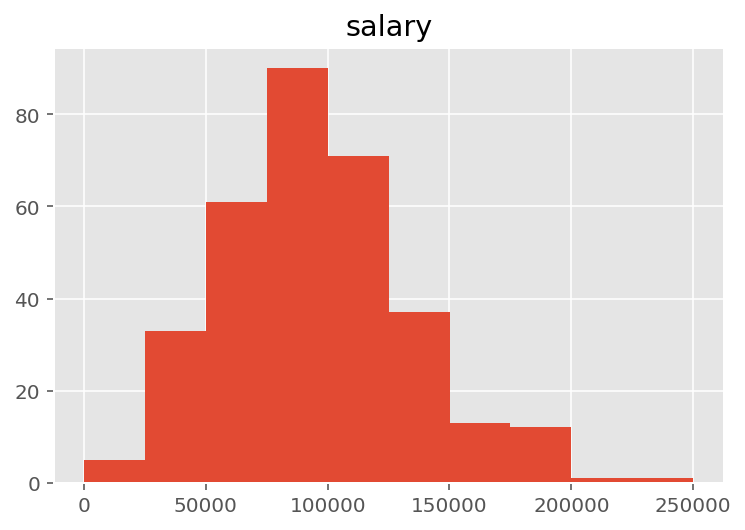

In [247]:
pd.DataFrame(salaries).hist('salary')

### Change the data to binary variables - whether the salary was low or high (above the median)

In [ ]:
has_sal = df_new[df_new['salary'].notnull()]

The new, cleaned dataset is much smaller - only 324 rows instead of 1584.

In [249]:
has_sal.shape

(324, 4)

In [250]:
median = np.median(has_sal['salary'])

In [ ]:
has_sal['salary_binary'] = has_sal['salary'].apply(lambda x: 1 if x > median else 0)

#### Delete numbers from location

In [254]:
has_sal.loc[:,'location'] = has_sal.loc[:,'location'].str.replace('\d+', '')

### Fit the Model

In [259]:
y = has_sal['salary_binary']

In [260]:
X = has_sal[['company','job_title','location']]

In [261]:
X_dumm = pd.get_dummies(X)

In [262]:
X_dumm.shape

(324, 457)

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=10**10,solver='lbfgs')
logreg.fit(X_dumm, y)

### Use cross-validation in scikit-learn to evaluate the model.

#### What is the baseline accuracy for this model?

In [258]:
# The baseline accuracy will be 
np.median(y)

0.5

In [263]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

print(cross_val_score(logreg, X_dumm, y, cv=10))
print(np.mean(cross_val_score(logreg, X_dumm, y, cv=10)))

[ 0.76470588  0.58823529  0.78125     0.875       0.59375     0.5         0.625
  0.59375     0.40625     0.625     ]
0.635294117647


In [265]:
from sklearn import metrics

print(metrics.accuracy_score(y, yhat))
print(metrics.roc_auc_score(y, yhat))
print(metrics.confusion_matrix(y, yhat))
print(metrics.classification_report(y, yhat))


0.651234567901
0.651234567901
[[124  38]
 [ 75  87]]
             precision    recall  f1-score   support

          0       0.62      0.77      0.69       162
          1       0.70      0.54      0.61       162

avg / total       0.66      0.65      0.65       324



Accuracy is the correct predictions over the number of predictions. A random model would predict around the baseline (0.5 in this case).

Precision predicts the tp / tp+fp

Recall predicts tp / tp+fn


In this case, as I am predicting whether salary is above or below the median. The importance of each metric would depend on the exact use case. However, both are quite important - and thus I would use accuracy as the main evaluator for my model.

### Perform Regularisation

Especially given the number of variables - overfitting may be in an issue int his model. Because of this, it is useful to see if regularisation could help improve scores. The data below, however, shows that L1 Runs slightly better than L2 at standard regularisation, but no regularisation in fact has a better accuracy!

####  L2 Regularization:

In [276]:
logreg_l2 = LogisticRegression(penalty='l2',random_state=1)
logreg_l2.fit(X_dumm, y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [277]:
yhat_l2 = cross_val_predict(logreg_l2, X_dumm, y)

In [278]:
print(metrics.accuracy_score(y, yhat_l2))
print(metrics.roc_auc_score(y, yhat_l2))
print(metrics.confusion_matrix(y, yhat_l2))
print(metrics.classification_report(y, yhat_l2))

0.577160493827
0.577160493827
[[141  21]
 [116  46]]
             precision    recall  f1-score   support

          0       0.55      0.87      0.67       162
          1       0.69      0.28      0.40       162

avg / total       0.62      0.58      0.54       324



####  L1 Regularization:

In [279]:
logreg_l1 = LogisticRegression(penalty='l1',random_state=1)
logreg_l1.fit(X_dumm, y)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [280]:
yhat_l1 = cross_val_predict(logreg_l1, X_dumm, y)

In [281]:
print(metrics.accuracy_score(y, yhat_l1))
print(metrics.roc_auc_score(y, yhat_l1))
print(metrics.confusion_matrix(y, yhat_l1))
print(metrics.classification_report(y, yhat_l1))

0.558641975309
0.558641975309
[[144  18]
 [125  37]]
             precision    recall  f1-score   support

          0       0.54      0.89      0.67       162
          1       0.67      0.23      0.34       162

avg / total       0.60      0.56      0.50       324



## Conclusion

This project scraped job data, cleaned it, and then created a logistic regresion algorithm which predicts whether a job will pay above or below average salaries with 65% accuracy - with similar values for precision and recall. Given the baseline is 50%, the algorithm provides an improvement, but not an extremely accurate one. As a possible future improvement, a tokenizer could be implemented to improve the interpretation of text data.